<a href="https://colab.research.google.com/github/ebuehrle/tl-assoc/blob/main/tf2g2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 74.6 MB/s eta 0:00:00


In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def rR(r1, r2):
  return np.array([
      [r1, -r2],
      [r2, r1]
  ])

In [4]:
def rT(t1, t2):
  return np.array([t1, t2])

In [5]:
mean = lambda A: sum(A[i, :] for i in range(A.shape[0])) / A.shape[0]

In [6]:
X = np.array([
	[0, 2],
	[0.5, 1.5],
	[1, 2],
	[1, 3],
])
X

array([[0. , 2. ],
       [0.5, 1.5],
       [1. , 2. ],
       [1. , 3. ]])

In [7]:
# Y2D = (X - mean(X)) @ rR(np.cos(0.1), np.sin(0.1)).T + rT(1., 0.5) + mean(X)
Y2D = (X - mean(X)) @ rR(np.cos(0.2), np.sin(0.2)).T + rT(1., 0.5) + mean(X)
Y2D = np.concatenate([
    Y2D,
    np.array([
        [1.3, 1.5],
        [3, 3],
        [2.1, 2.3],
        [-1.2, 3],
    ])
], 0)
Y2D

array([[ 1.03729206,  2.37832335],
       [ 1.62666001,  1.98762472],
       [ 2.01735863,  2.57699268],
       [ 1.8186893 ,  3.55705925],
       [ 1.3       ,  1.5       ],
       [ 3.        ,  3.        ],
       [ 2.1       ,  2.3       ],
       [-1.2       ,  3.        ]])

In [8]:
Y2D = np.array([[ 1.03729206,  2.37832335],
       [ 1.62666001,  1.98762472],
       #[ 2.01735863,  2.57699268],
       [ 1.8186893 ,  3.55705925],
       [ 1.3       ,  1.5       ],
       [ 3.        ,  3.        ],
       #[ 2.1       ,  2.3       ],
       [-1.2       ,  3.        ]])

In [9]:
C1 = np.array([0., 0.])

In [10]:
C2 = np.array([1., 0.])

In [11]:
Y1 = C1 + (Y2D - C1) / (Y2D - C1)[:, -1:]
Y1

array([[ 0.43614425,  1.        ],
       [ 0.81839393,  1.        ],
       [ 0.51129013,  1.        ],
       [ 0.86666667,  1.        ],
       [ 1.        ,  1.        ],
       [-0.4       ,  1.        ]])

In [12]:
Y2 = C2 + (Y2D - C2) / (Y2D - C2)[:, -1:]
Y2

array([[1.01567998, 1.        ],
       [1.31528085, 1.        ],
       [1.23015903, 1.        ],
       [1.2       , 1.        ],
       [1.66666667, 1.        ],
       [0.26666667, 1.        ]])

In [13]:
P = np.exp(-0.05*(X**2).sum(axis=1))
P

array([0.81873075, 0.8824969 , 0.77880078, 0.60653066])

In [14]:
CC = np.eye(Y1.shape[0], Y2.shape[0])
CC

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [15]:
L2 = lambda A: sum(A[i, :] @ A[i, :] for i in range(A.shape[0]))
JC = lambda R, T, S1, N1, X, Y1, S2, N2, Y2: L2((X - mean(X)) @ R.T + mean(X) + T.T - (S1 @ (Y1 - C1) + C1) - N1) \
      + L2((X - mean(X)) @ R.T + mean(X) + T.T - (S2 @ (Y2 - C2) + C2) - N2) \
      + L2((S1 @ (Y1 - C1) + C1 + N1) - ((S2 @ (Y2 - C2)) + C2 + N2))

In [16]:
m = gp.Model()

R = m.addMVar(shape=(2, 2), lb=-GRB.INFINITY)
T = m.addMVar(shape=(2, 1), lb=-GRB.INFINITY)

SB1 = m.addMVar(shape=(X.shape[0], Y1.shape[0]), vtype=GRB.BINARY)
NB1 = m.addMVar(shape=(X.shape[0], 1), vtype=GRB.BINARY)
[m.addSOS(GRB.SOS_TYPE1, SB1[i, :].tolist() + NB1[i].tolist()) for i in range(SB1.shape[0])]
[m.addConstr(sum(SB1[i, :]) + sum(NB1[i, :]) >= 1) for i in range(SB1.shape[0])]
[m.addSOS(GRB.SOS_TYPE1, SB1[:, i].tolist()) for i in range(SB1.shape[1])]

S1 = m.addMVar(shape=SB1.shape)
[m.addConstr((SB1[i, j] == 0) >> (S1[i, j] == 0)) for i in range(SB1.shape[0]) for j in range(SB1.shape[1])]
N1 = m.addMVar(shape=(X.shape[0], Y1.shape[1]), lb=-GRB.INFINITY)
[m.addConstr((NB1[i, 0] == 0) >> (N1[i, j] == 0)) for i in range(NB1.shape[0]) for j in range(Y1.shape[1])]

SB2 = m.addMVar(shape=(X.shape[0], Y2.shape[0]), vtype=GRB.BINARY)
NB2 = m.addMVar(shape=(X.shape[0], 1), vtype=GRB.BINARY)
[m.addSOS(GRB.SOS_TYPE1, SB2[i, :].tolist() + NB2[i].tolist()) for i in range(SB2.shape[0])]
[m.addConstr(sum(SB2[i, :]) + sum(NB2[i, :]) >= 1) for i in range(SB2.shape[0])]
[m.addSOS(GRB.SOS_TYPE1, SB2[:, i].tolist()) for i in range(SB2.shape[1])]

S2 = m.addMVar(shape=SB2.shape)
[m.addConstr((SB2[i, j] == 0) >> (S2[i, j] == 0)) for i in range(SB2.shape[0]) for j in range(SB2.shape[1])]
N2 = m.addMVar(shape=(X.shape[0], Y2.shape[1]), lb=-GRB.INFINITY)
[m.addConstr((NB2[i, 0] == 0) >> (N2[i, j] == 0)) for i in range(NB2.shape[0]) for j in range(Y2.shape[1])]

r1 = R[0, 0]
r2 = R[1, 0]

m.setObjective(100*JC(R, T, S1, N1, X, Y1, S2, N2, Y2) + NB1.T @ P + NB2.T @ P + (r1 - 1)*(r1 - 1) + r2*r2
               - sum(SB1[i, :] @ CC @ SB2[i, :].T for i in range(SB1.shape[0])), GRB.MINIMIZE)
m.addConstr(R[0, 0] == R[1, 1])
m.addConstr(R[0, 1] == -R[1, 0])

Restricted license - for non-production use only - expires 2024-10-28


<MConstr () *awaiting model update*>

In [17]:
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 10 rows, 126 columns and 60 nonzeros
Model fingerprint: 0xc3994a40
Model has 896 quadratic objective terms
Model has 20 SOS constraints
Model has 64 general constraints
Variable types: 70 continuous, 56 integer (56 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 3e+03]
  QObjective range [8e-01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 52 rows and 40 columns
Presolve time: 0.01s
Presolved: 62 rows, 166 columns, 188 nonzeros
Presolved model has 64 SOS constraint(s)
Presolved model has 944 quadratic objective terms
Variable types: 70 continuous, 96 integer (96 binary)
Found heuristic solution: objective 602.3199358

Root relaxation:

In [18]:
R.X

array([[ 0.98005819, -0.19792735],
       [ 0.19792735,  0.98005819]])

In [19]:
T.X

array([[0.99989086],
       [0.49977236]])

In [20]:
S1.X

array([[2.37846701, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 1.98732891, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.5568284 , 0.        , 0.        ,
        0.        ]])

In [21]:
S2.X

array([[2.37851265, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 1.98731452, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.55675172, 0.        , 0.        ,
        0.        ]])

In [22]:
NB1.X

array([[0.],
       [0.],
       [1.],
       [0.]])

In [23]:
N1.X

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [2.0171536 , 2.57648785],
       [0.        , 0.        ]])

In [24]:
NB2.X

array([[0.],
       [0.],
       [1.],
       [0.]])

In [25]:
N2.X

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [1.0171536 , 2.57648785],
       [0.        , 0.        ]])

In [26]:
YT1 = S1.X @ (Y1 - C1) + C1

In [27]:
YT2 = S2.X @ (Y2 - C2) + C2

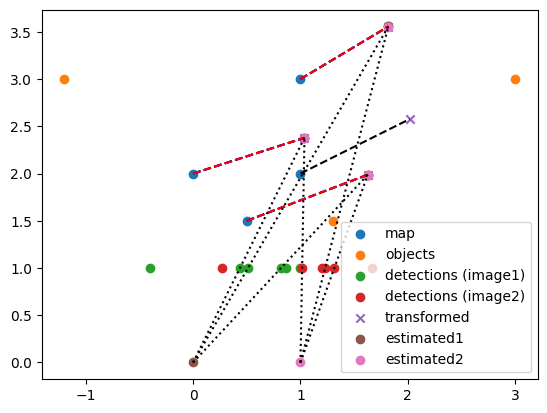

In [28]:
XT = (X - mean(X)) @ R.X.T + mean(X) + T.X.T
plt.scatter(X[:,0], X[:,1])
plt.scatter(Y2D[:,0], Y2D[:,1])
plt.scatter(Y1[:,0], Y1[:,1])
plt.scatter(Y2[:,0], Y2[:,1])
plt.scatter(XT[:,0], XT[:,1], marker='x')
plt.scatter(YT1[:,0], YT1[:,1])
plt.scatter(YT2[:,0], YT2[:,1])
plt.legend(("map", "objects", "detections (image1)", "detections (image2)", "transformed", "estimated1", "estimated2"))

P0 = X
P1 = XT
#P0 = P0[N.X==0, :]
#P1 = P1[N.X==0, :]
plt.plot(
  np.stack([P0[:,0], P1[:,0]], 1).T,
  np.stack([P0[:,1], P1[:,1]], 1).T,
  'k--'
)

P0 = XT
P1 = YT1
P0 = P0[NB1.X.squeeze()==0, :]
P1 = P1[NB1.X.squeeze()==0, :]
plt.plot(
  np.stack([P0[:,0], P1[:,0]], 1).T,
  np.stack([P0[:,1], P1[:,1]], 1).T,
  'k--'
)

P0 = X
P1 = SB1.X @ Y2D
P0 = P0[NB1.X.squeeze()==0, :]
P1 = P1[NB1.X.squeeze()==0, :]
plt.plot(
  np.stack([P0[:,0], P1[:,0]], 1).T,
  np.stack([P0[:,1], P1[:,1]], 1).T,
  'b--'
)

P0 = X
P1 = SB2.X @ Y2D
P0 = P0[NB2.X.squeeze()==0, :]
P1 = P1[NB2.X.squeeze()==0, :]
plt.plot(
  np.stack([P0[:,0], P1[:,0]], 1).T,
  np.stack([P0[:,1], P1[:,1]], 1).T,
  'r--'
)

P0 = np.tile(C1, (YT1.shape[0], 1))
P1 = YT1
plt.plot(
  np.stack([P0[:,0], P1[:,0]], 1).T,
  np.stack([P0[:,1], P1[:,1]], 1).T,
  'k:'
)

P0 = np.tile(C2, (YT2.shape[0], 1))
P1 = YT2
plt.plot(
  np.stack([P0[:,0], P1[:,0]], 1).T,
  np.stack([P0[:,1], P1[:,1]], 1).T,
  'k:'
)

plt.show()

In [29]:
scale = np.sqrt(r1.X**2+r2.X**2)
scale

0.9998446360614955

In [30]:
rotation = np.arctan2(r2.X, r1.X)
rotation

0.19927436510128177

In [31]:
translation = T.X
translation

array([[0.99989086],
       [0.49977236]])